In [1]:
from astropy.io import fits

%load_ext autoreload 

In [2]:

file_path = '../cals_230728_183018.fts'


hdul = fits.open(file_path)
hdul.info()

for hdu in hdul:
            # Print header information
            print("Header:")
            print(hdu.header)

            # Print data if it's an image
            if hdu.is_image:
                hduIMG = hdu
                print("Image data:")
                (hduIMG.data).shape  # This is a NumPy array




Filename: ../cals_230728_183018.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (720, 720, 41, 4)   int16   
Header:
SIMPLE  =                    T / Written by IDL:  Thu Aug 10 03:23:25 2023      BITPIX  =                   16 / data type of original image                    NAXIS   =                    4 / dimension of original image                    NAXIS1  =                  720 / Number of positions along axis 1               NAXIS2  =                  720 / Number of positions along axis 2               NAXIS3  =                   41 / Number of positions along axis 3               NAXIS4  =                    4 / Number of positions along axis 4               CTYPE1  = 'E-W ARCS'                                                            CTYPE2  = 'N-S ARCS'                                                            CRVAL1  =                    0                                                  CRVAL2  =              

In [3]:
x_idx, y_idx = 300, 500
profile_IQUV = hduIMG.data[:,:,x_idx,y_idx].squeeze()

Text(0.1, 0.8, 'V')

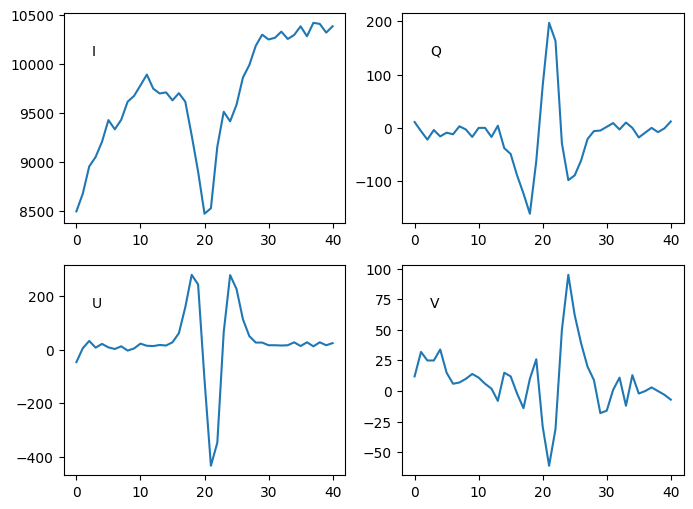

In [4]:
# plot IQUV in 2*2 subplots
import matplotlib.pyplot as plt
import numpy as np

fig, axsall = plt.subplots(2,2, figsize=(8,6))
axs = axsall.flatten()

axs[0].plot(profile_IQUV[0,:])
axs[0].text(0.1, 0.8, 'I', transform=axs[0].transAxes)
axs[1].plot(profile_IQUV[1,:])
axs[1].text(0.1, 0.8, 'Q', transform=axs[1].transAxes)
axs[2].plot(profile_IQUV[2,:])
axs[2].text(0.1, 0.8, 'U', transform=axs[2].transAxes)
axs[3].plot(profile_IQUV[3,:])
axs[3].text(0.1, 0.8, 'V', transform=axs[3].transAxes)



In [5]:
import mlx

In [6]:
a = hdul[0].data.T
h = hdul[0].header

In [7]:
def fxpar(header, key):
    """Retrieve the value of a header key from a FITS file."""
    return header[key]

nx, ny, nw, nstocks = a.shape


In [8]:
if 1:   
        lambda_rest = fxpar(h, 'REFWV')
        dlambda = np.arange(fxpar(h, 'NAXIS3')) * fxpar(h, 'INCWV') + fxpar(h, 'STARTWV')

        s = np.where(np.abs(dlambda) <= 2.5)[0]
        factor = np.median(a[:, :, 40 < (nw - 1), 0])

        # Initialize arrays
        bmag = np.zeros((nx, ny))
        inclination = np.zeros((nx, ny))
        azimuth = np.zeros((nx, ny))
        chisqa = np.zeros((nx, ny))
        inta = np.zeros((nx, ny))
        parmap = np.zeros((nx, ny, 9))
        fit_array = np.zeros((nx, ny, len(s), 4))
        original = np.zeros((nx, ny, len(s), 4))


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
xpos, ypos = x_idx, y_idx


x = dlambda[s]
b1 = a[xpos, ypos, s, :]

In [12]:
%%capture

from invFuncs import init_par, niris_mefit, niris_MEsinglet
bmag = np.zeros((nx, ny))
inclination = np.zeros((nx, ny))
azimuth = np.zeros((nx, ny))
chisqa = np.zeros((nx, ny))
inta = np.zeros((nx, ny))
parmap = np.zeros((nx, ny, 9))
lambda_rest = fxpar(h, 'REFWV')
dlambda = np.arange(fxpar(h, 'NAXIS3')) * fxpar(h, 'INCWV') + fxpar(h, 'STARTWV')
s_indices = np.where(np.abs(dlambda) <= 2.5)[0]
n = len(s_indices)

b = a
[nx, ny, nw, nstocks] = a.shape
factor = np.median(b[:, :, :, 0])
fit_array = np.zeros((nx, ny, len(s_indices), 4))
original = np.zeros((nx, ny, len(s_indices), 4))
x = dlambda[s_indices]
cont_indices = np.where(np.abs(x[:len(x) - 1]) >= 1.5)[0]
if len(cont_indices) == 0:
    cont_indices = np.where(np.abs(x[:len(x) - 1]) >= 1)[0]

for xpos in np.arange(180,640):
    for ypos in np.arange(180,640):
        # Assuming fxpar is a function to extract parameters from the header 'h'
        b1 = b[xpos, ypos, s_indices, :]
        data = b1 / factor
        for k in range(1, 4):
            data[:, k] = data[:, k] - np.median(data[cont_indices, k])
        par = init_par(x, data)
        original[xpos, ypos, :, :] = data
        try:
            result = niris_mefit(x, data, par,niris_MEsinglet)
            dataIQUV = niris_MEsinglet(x, * result)
            fit_array[xpos, ypos, :, :] = np.stack([dataIQUV[i*len(x):(i+1)*len(x)] for i in range(4)]).T
        except:
            result = np.zeros(9)
            #print('Error at xpos, ypos', xpos, ypos)

        bmag[xpos, ypos] = result[0]
        inclination[xpos, ypos] = result[1]
        azimuth[xpos, ypos] = result[2]
        inta[xpos, ypos] = result[7] + result[8]
        parmap[xpos, ypos, :] = result


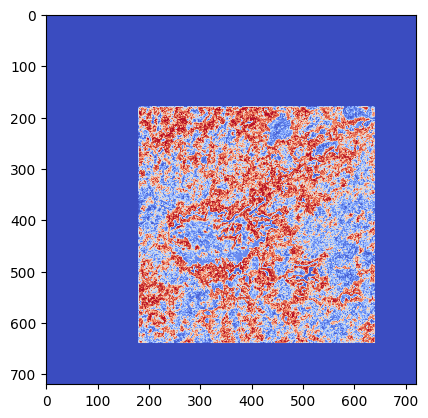

In [15]:
plt.imshow(bmag, cmap='coolwarm')